In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
os.environ['CUDA_VISIBLE_DEVICES'] = "7"

isola-h100-1.csail.mit.edu
/vision-nfs/isola/env/akumar01/nca-alife
/vision-nfs/isola/env/akumar01/.virtualenvs/nca-alife/bin/python


In [2]:
import os, sys, glob, pickle
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat

In [3]:
import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

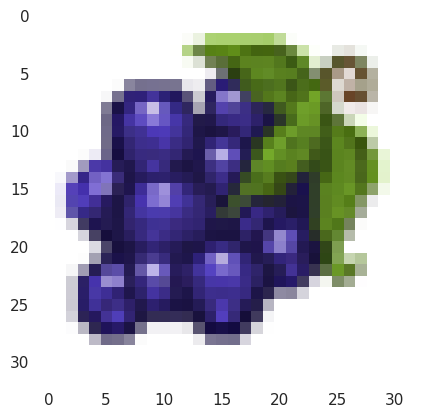

In [113]:
from PIL import Image 
img = Image.open("img.jpg") 
img = img.resize((32, 32))
img = np.array(img)
img = img/255.
img = jnp.array(img.astype(np.float32))
plt.imshow(img)
plt.grid(False)

In [114]:
class NCA(nn.Module):
    n_layers: int
    d_embd: int
    kernel_size: int = 3
    nonlin: str = 'gelu'
    p_drop: float = 0.0
    
    @nn.compact
    def __call__(self, _rng, xin):
        H, W, D_in = xin.shape
        x = xin
        for _ in range(self.n_layers):
            x = nn.Conv(features=self.d_embd, kernel_size=(self.kernel_size, self.kernel_size))(x)
            # x = nn.LayerNorm()(x)
            x = getattr(nn, self.nonlin)(x)
            # x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        # x = nn.Conv(features=D_in, kernel_size=(kernel_size, kernel_size))(x)
        x = nn.Conv(features=D_in, kernel_size=(1, 1))(x)
        x = x*1e-2
        mask = 1-(jax.random.uniform(_rng, (H, W)) < self.p_drop)
        return xin + x * mask[:, :, None]

In [115]:
rng = jax.random.PRNGKey(0)
H, W, D = 32, 32, 16
T = 64
nca = NCA(n_layers=2, d_embd=64)

def get_video(_rng, params):
    x = jnp.ones((H, W, D))
    # x = x.at[:, :, :3].set(img)
    x = x.at[H//2, W//2, :].set(0.)
    def forward_step(x, _rng):
        x = nca.apply(params, _rng, x)
        return x, x
    x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
    return vid

In [116]:
x = jax.random.normal(rng, (H, W, D))
params = nca.init(rng, rng, x)

# tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(3e-4, weight_decay=0., eps=1e-8))
tx = optax.chain(optax.clip_by_global_norm(1.), optax.adamw(2e-3, weight_decay=0., eps=1e-8))
train_state = TrainState.create(apply_fn=nca.apply, params=params, tx=tx)
bs = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 16)


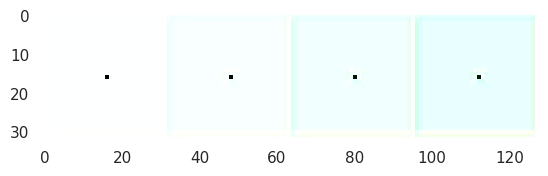

In [117]:
vid = get_video(rng, train_state.params)
print(vid.shape)
plt.imshow(rearrange(vid[::16, ..., :3], "(R C) H W D -> (R H) (C W) D", R=1))
plt.grid(False)

In [118]:
@jax.jit
def train_step(train_state, _rng):
    def loss_fn(params):
        vid = jax.vmap(get_video, in_axes=(0, None))(split(_rng, bs), params)
        pred = vid[:, -1, :, :, :3]
        loss = ((pred-img)**2).mean()
        return loss
    loss, grads = jax.value_and_grad(loss_fn)(train_state.params)
    train_state = train_state.apply_gradients(grads=grads)
    return train_state, loss

  0%|          | 0/5001 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.3258816]
(64, 32, 32, 16)


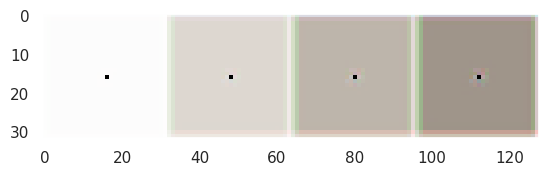

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00680855]
(64, 32, 32, 16)


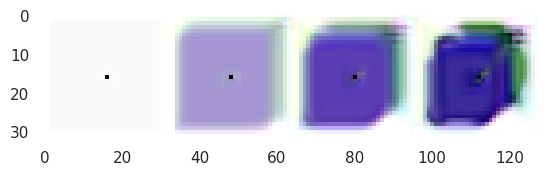

[0.00063847]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 16)


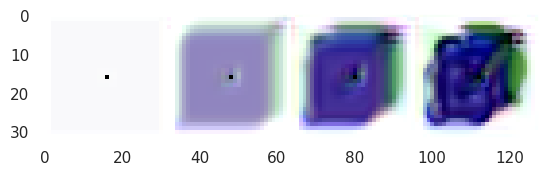

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00018856]
(64, 32, 32, 16)


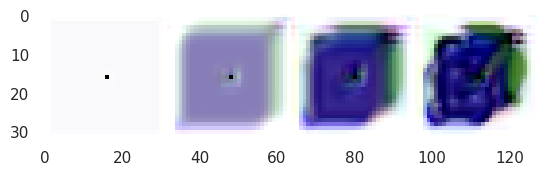

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[8.1210004e-05]
(64, 32, 32, 16)


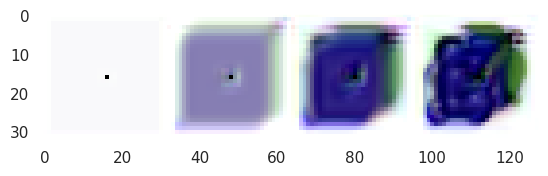

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.00072722]
(64, 32, 32, 16)


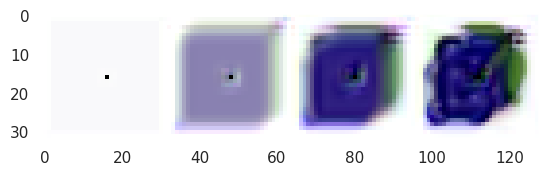

In [119]:
losses = []
pbar = tqdm(range(5000+1))
for i in pbar:
    train_state, loss = jax.lax.scan(train_step, train_state, split(rng, 1))
    losses.extend(loss.tolist())
    pbar.set_postfix(log_loss=np.log(losses[-1]))
    if i%1000==0:
        print(loss)
        vid = get_video(rng, train_state.params)
        print(vid.shape)
        plt.imshow(rearrange(vid[::16, ..., :3], "(R C) H W D -> (R H) (C W) D", R=1))
        plt.grid(False)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 16)


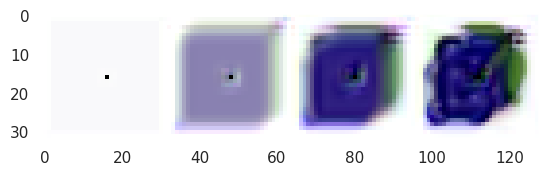

In [121]:
vid = get_video(rng, train_state.params)
print(vid.shape)
plt.imshow(rearrange(vid[::16, ..., :3], "(R C) H W D -> (R H) (C W) D", R=1))
plt.grid(False)

In [ ]:
plt.subplot(121)
plt.imshow(vid[-1, ..., :3])
plt.grid(False)
plt.subplot(122)
plt.imshow(img)
plt.grid(False)

In [89]:
df = pd.DataFrame(dict(step=np.arange(len(losses)), loss=losses))
df['loss_smooth'] = df['loss'].ewm(span=1000).mean()
df

,step,loss,loss_smooth
0,0,0.325882,0.325882
1,1,0.132321,0.229004
2,2,0.181975,0.213296
3,3,0.128352,0.191997
4,4,0.123180,0.178178
...,...,...,...
9996,9996,0.000265,0.000309
9997,9997,0.000281,0.000308
9998,9998,0.000208,0.000308
9999,9999,0.000242,0.000308


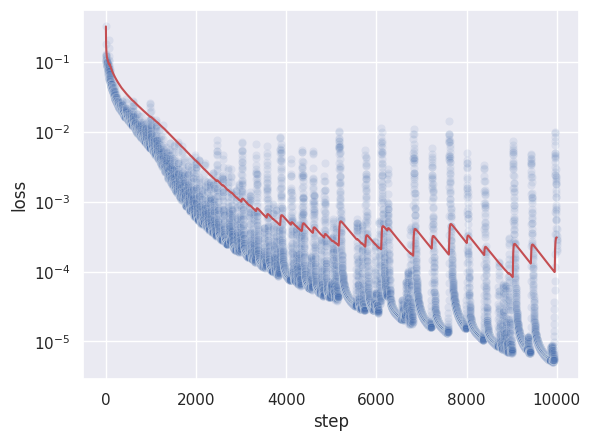

In [90]:
sns.scatterplot(data=df, x='step', y='loss', alpha=0.1)
sns.lineplot(data=df, x='step', y='loss_smooth', c='r')
plt.yscale('log')

In [73]:
sum([p.size for p in jax.tree.flatten(params)[0]])

47248

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 32, 32, 16)


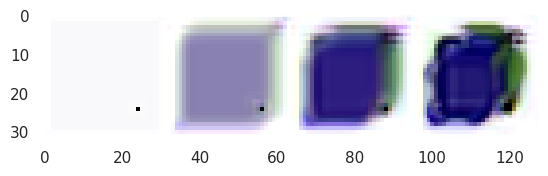

In [131]:
def get_video(_rng, params):
    x = jnp.ones((H, W, D))
    # x = x.at[:, :, :3].set(img)
    x = x.at[H//2+8, W//2+8, :].set(0.)
    x = x.at[H, W, :].set(0.)
    def forward_step(x, _rng):
        x = nca.apply(params, _rng, x)
        return x, x
    x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
    return vid


vid = get_video(rng, train_state.params)
print(vid.shape)
plt.imshow(rearrange(vid[::16, ..., :3], "(R C) H W D -> (R H) (C W) D", R=1))
plt.grid(False)

In [4]:
# random NCAs

In [70]:
class NCA(nn.Module):
    n_layers: int
    d_embd: int
    kernel_size: int = 3
    nonlin: str = 'gelu'
    p_drop: float = 0.0
    
    @nn.compact
    def __call__(self, _rng, xin):
        H, W, D_in = xin.shape
        x = xin
        for _ in range(self.n_layers):
            x = nn.Conv(features=self.d_embd, kernel_size=(self.kernel_size, self.kernel_size))(x)
            # x = nn.LayerNorm()(x)
            x = getattr(nn, self.nonlin)(x)
            # x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        # x = nn.Conv(features=D_in, kernel_size=(kernel_size, kernel_size))(x)
        x = nn.Conv(features=D_in, kernel_size=(1, 1))(x)
        x = x*1e-2
        mask = 1-(jax.random.uniform(_rng, (H, W)) < self.p_drop)
        x = xin + x * mask[:, :, None]
        # return jnp.clip(x, min=-2, max=2)
        return x/jnp.linalg.norm(x, axis=-1, keepdims=True)


In [71]:
rng = jax.random.PRNGKey(0)
H, W, D = 128, 128, 64
T = 64
nca = NCA(n_layers=2, d_embd=64)

x = jax.random.normal(rng, (H, W, D))
params = nca.init(rng, rng, x)

# def get_video(_rng, params):
#     x = jax.random.normal(_rng, (256, 256))
#     def forward_step(x, _rng):
#         x = nca.apply(params, _rng, x)
#         return x, x
#     x, vid = jax.lax.scan(forward_step, x, split(_rng, T))
#     return vid

In [72]:
forward_fn = jax.jit(nca.apply)
for _ in tqdm(range(100000)):
    x = forward_fn(params, rng, x)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
x = forward_fn(params, rng, x)

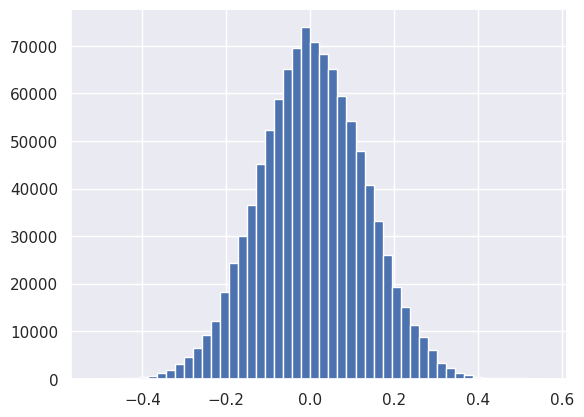

In [73]:
plt.hist(x.flatten(), bins=50);